In [2]:
import os, glob
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [3]:
import numpy as np
import PIL

In [4]:
image_dir = '/content/drive/MyDrive/Input Data/images/'
image_files = glob.glob(f"{image_dir}*.jpg")
# Sort list of files in directory by size 
img_var = sorted( image_files,key =  lambda x: os.stat(x).st_size,reverse=True )

# checking the variation in the image datasets
max_hieght, max_width, _ = np.array(PIL.Image.open(img_var[0])).shape
min_hieght, min_width, _ = np.array(PIL.Image.open(img_var[-1])).shape
print(max_hieght, max_width, min_hieght, min_width)



3600 2400 108 144


In [5]:
#Randomly checking max and min pixel variations among image datasets
for i in image_files[5100:5110]: 
  img_array = np.array(PIL.Image.open(image_files[0]))
  print(f"max_pixel value:{np.min(img_array)}")
  print(f"max_pixel value:{np.max(img_array)}")

max_pixel value:0
max_pixel value:255
max_pixel value:0
max_pixel value:255
max_pixel value:0
max_pixel value:255
max_pixel value:0
max_pixel value:255
max_pixel value:0
max_pixel value:255
max_pixel value:0
max_pixel value:255
max_pixel value:0
max_pixel value:255
max_pixel value:0
max_pixel value:255
max_pixel value:0
max_pixel value:255
max_pixel value:0
max_pixel value:255


In [6]:
features = []
for i in image_files:
  try:
      img = PIL.Image.open(i)
      img = img.resize((100,100))
      if np.array(img).size ==30000:
        features.append(np.array(img).astype("float")/255.0)
        
  except:
      pass

In [7]:
features1 = np.array([i.reshape(-1) for i in features])
features1.shape

(6227, 30000)

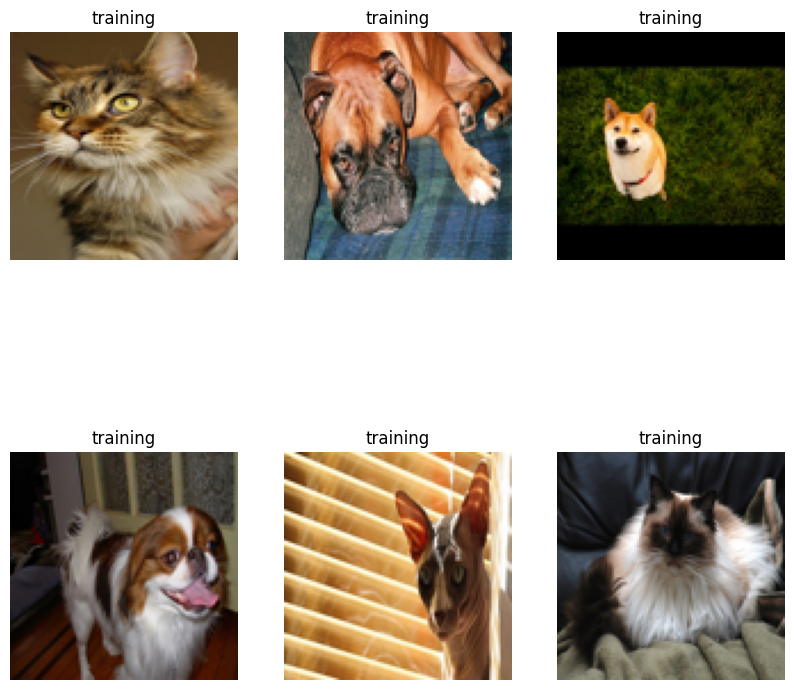

In [8]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(features[i])
    plt.title('training')
    plt.axis("off")

Normalize the features
For most image data, the pixel values are integers with values between 0 and 255.

Neural networks process inputs using small weight values, and inputs with large integer values can disrupt or slow down the learning process. As such it is good practice to normalize the pixel values.

Hint: sklearn.preprocessing.normalize

In [9]:
from sklearn import preprocessing

In [10]:
image_array = np.array(features)
image_array

array([[[[0.29803922, 0.20784314, 0.11372549],
         [0.29411765, 0.20784314, 0.10588235],
         [0.2745098 , 0.19607843, 0.09803922],
         ...,
         [0.31372549, 0.22745098, 0.10196078],
         [0.31372549, 0.22745098, 0.10196078],
         [0.32156863, 0.21960784, 0.09803922]],

        [[0.30980392, 0.20784314, 0.11372549],
         [0.30196078, 0.20392157, 0.10980392],
         [0.26666667, 0.19215686, 0.09411765],
         ...,
         [0.31764706, 0.22745098, 0.10196078],
         [0.32156863, 0.22352941, 0.10196078],
         [0.32156863, 0.22352941, 0.10196078]],

        [[0.30196078, 0.20784314, 0.11764706],
         [0.30588235, 0.20392157, 0.10588235],
         [0.30588235, 0.20784314, 0.10980392],
         ...,
         [0.32156863, 0.22745098, 0.10588235],
         [0.32156863, 0.22745098, 0.10588235],
         [0.32156863, 0.22745098, 0.10588235]],

        ...,

        [[0.41176471, 0.34901961, 0.25098039],
         [0.41568627, 0.35294118, 0.25098039]

In [11]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(image_array, test_size=0.2, random_state=40)

In [12]:
train_data.shape, test_data.shape

((4981, 100, 100, 3), (1246, 100, 100, 3))

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import os
import PIL


class ConvAutoencoder:
    def __init__(self, input_shape):
        self.input_shape = input_shape
        self.encoder = None
        self.decoder = None
        self.autoencoder = None


    def build_encoder(self):
        input_img = keras.Input(shape=self.input_shape)

        # Encoder Layers
        x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
        x = layers.MaxPooling2D((2, 2), padding='same')(x)
        x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
        x = layers.MaxPooling2D((2, 2), padding='same')(x)
        x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
        encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

        self.encoder = keras.Model(input_img, encoded)
        self.encoder.summary()
        return encoded.shape[1:]

    def build_decoder(self, inputShape):
        # Decoder Layers
        encoded_input = keras.Input(shape=inputShape)
        x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded_input)
        x = layers.UpSampling2D((2, 2))(x)
        x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
        x = layers.UpSampling2D((2, 2))(x)
        x = layers.Conv2D(16, (3, 3), activation='relu')(x)
        x = layers.UpSampling2D((2, 2))(x)
        decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

        self.decoder = keras.Model(encoded_input, decoded)
        self.decoder.summary()

    def build_autoencoder(self):
        input_img = keras.Input(shape=self.input_shape)
        encoded = self.encoder(input_img)
        decoded = self.decoder(encoded)
        self.autoencoder = keras.Model(input_img, decoded)
        self.autoencoder.summary()

        self.autoencoder.compile(optimizer='adam', loss='mse')

    def train(self, x_train, x_test, epochs, batch_size):
        self.autoencoder.fit(x_train,x_train,
                             epochs=epochs,
                             batch_size=batch_size,
                             shuffle=True,
                             validation_data=(x_test, x_test))

    def restore(self, x):
        restored_imgs = self.autoencoder.predict(x)
        return restored_imgs




In [14]:
# Example Usage
if __name__ == '__main__':
    # Load the data
    # (x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
    
    # Initialize the Convolutional Autoencoder
    autoencoder = ConvAutoencoder(input_shape=(100, 100,3))

    # Preprocessing the data
    # x_train = autoencoder.preprocess_data(image_files,'training', 32)
    # x_test =  autoencoder.preprocess_data(image_files, 'validation', 32)

    # Build the encoder, decoder and autoencoder
    outputShape = autoencoder.build_encoder()
    autoencoder.build_decoder(outputShape)
    autoencoder.build_autoencoder()
    # Train the autoencoder on the training
    # Train the model
    print('-------Training Starts ---------')
    autoencoder.train(train_data, test_data,  epochs=10, batch_size=32 )

    # Use the trained model to restore images
    # testimg = glob.glob('/content/drive/MyDrive/Input Data/*.jpg')
    restored_imgs = autoencoder.restore(test_data)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 8)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 8)         584   

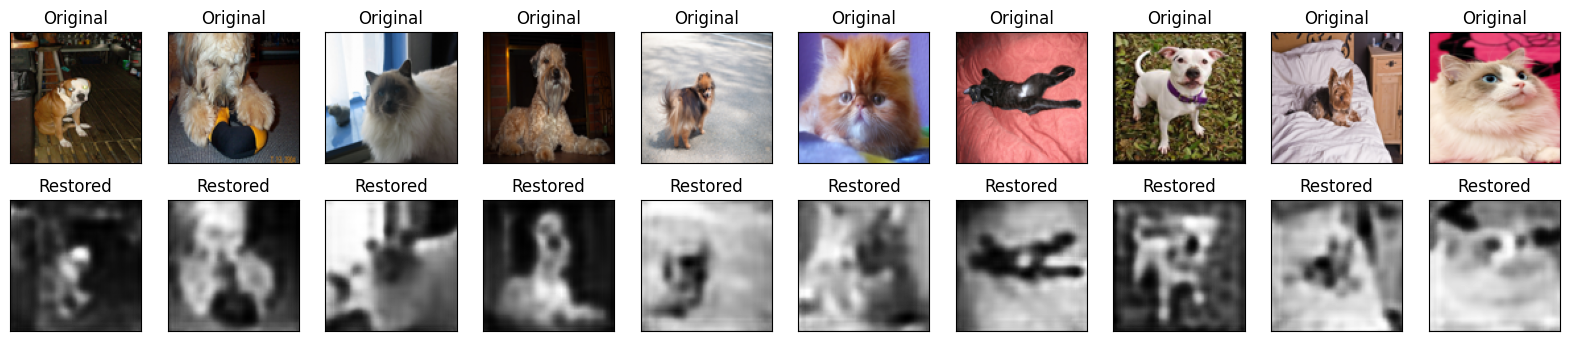

In [23]:
# Display some sample results
import matplotlib.pyplot as plt
n = 10  # number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_data[i])
    plt.title("Original")
 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display restored images
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(restored_imgs[i])
    plt.title("Restored")

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()